In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Support Vector Machines

(com material adaptado do livro texto)

## Classificação

In [2]:
def plot_predictions(clf, axes):
    # Constroi uma lista de valores das variáveis independentes
    # que cubra o espaço amostral.
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]

    # Constroi as predições (binárias) e a função de decisão (contínua).
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)

    # Desenha a curva de decisão e as curvas de nível da função de decisão.
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)


def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "bs")
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

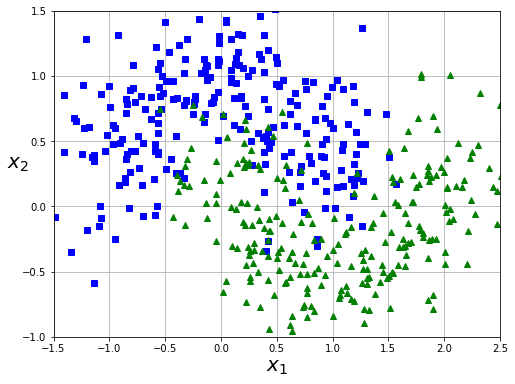

In [3]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=RANDOM_SEED)

plt.figure(figsize=(8, 6))
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

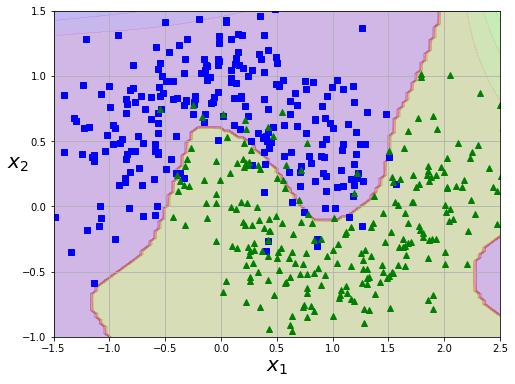

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import LinearSVC, SVC

# Equivale a:
#
# poly_features = PolynomialFeatures(degree=7)
# scaler = StandardScaler()
# svm_clf = LinearSVC(C=1e-5, dual=False, random_state=RANDOM_SEED)

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=7)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=1e5, dual=False, random_state=RANDOM_SEED)),
])

# Equivale a:
#
# X1 = poly_features.fit_transform(X)  # Não faz nada.
# X2 = scaler.fit_transform(X1)  # Ajusta media e desvio padrao.
# X3 = svm_clf.fit(X2, y)

polynomial_svm_clf.fit(X, y)

# O polynomial_svm_clf.predict(X) equivale a:
#
# X1 = poly_features.transform(X)  # Não faz nada.
# X2 = scaler.transform(X1)  # Ajusta media e desvio padrao.
# X3 = svm_clf.predict(X2)

plt.figure(figsize=(8, 6))
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Fitting 100 folds for each of 16 candidates, totalling 1600 fits
{'svm_clf__C': 3.1622776601683795}


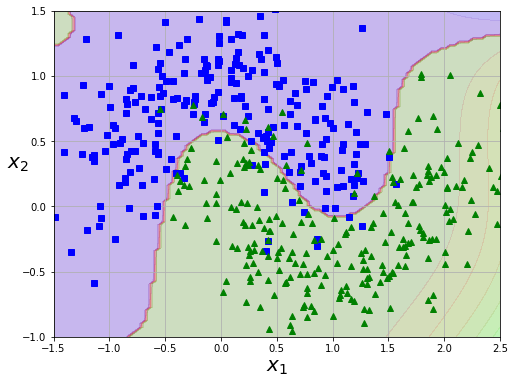

Wall time: 16 s


In [5]:
%%time
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from pprint import pprint

grid = GridSearchCV(
    polynomial_svm_clf,
    {
        'svm_clf__C': [10.0**k for k in np.arange(-3, 5, 0.5)],
    },
    scoring='accuracy',
    cv=ShuffleSplit(
        n_splits=100,
        test_size=0.33,
        random_state=RANDOM_SEED,
    ),
    n_jobs=-1,
    verbose=3,
)
grid.fit(X, y)

print(grid.best_params_)

plt.figure(figsize=(8, 6))
plot_predictions(grid, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

**Atividade:** 
- Como funciona e para que serve o ShuffleSplit que eu usei no GridSearchCV?

**R:**

Vamos analisar a acurácia real do classificador usando validação cruzada, e alterando o parâmetro de regularização $C$:

C = 0.00100: mean_accuracy = 0.849, stddev_accuracy = 0.027
C = 0.00316: mean_accuracy = 0.862, stddev_accuracy = 0.025
C = 0.01000: mean_accuracy = 0.871, stddev_accuracy = 0.024
C = 0.03162: mean_accuracy = 0.883, stddev_accuracy = 0.024
C = 0.10000: mean_accuracy = 0.904, stddev_accuracy = 0.021
C = 0.31623: mean_accuracy = 0.919, stddev_accuracy = 0.019
C = 1.00000: mean_accuracy = 0.923, stddev_accuracy = 0.019
C = 3.16228: mean_accuracy = 0.924, stddev_accuracy = 0.017
C = 10.00000: mean_accuracy = 0.922, stddev_accuracy = 0.019
C = 31.62278: mean_accuracy = 0.920, stddev_accuracy = 0.019
C = 100.00000: mean_accuracy = 0.918, stddev_accuracy = 0.018
C = 316.22777: mean_accuracy = 0.916, stddev_accuracy = 0.018
C = 1000.00000: mean_accuracy = 0.915, stddev_accuracy = 0.018
C = 3162.27766: mean_accuracy = 0.914, stddev_accuracy = 0.019
C = 10000.00000: mean_accuracy = 0.913, stddev_accuracy = 0.019
C = 31622.77660: mean_accuracy = 0.914, stddev_accuracy = 0.018


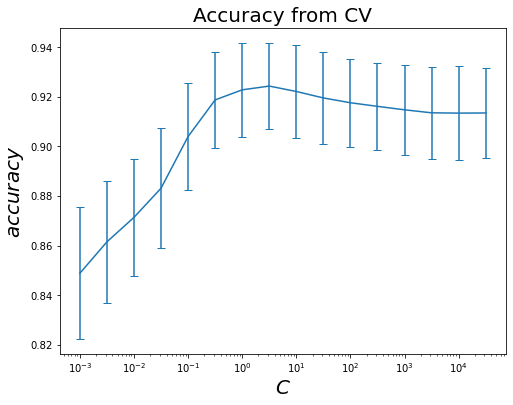

In [6]:
P = np.array([p['svm_clf__C'] for p in grid.cv_results_['params']])
M = grid.cv_results_['mean_test_score']
S = grid.cv_results_['std_test_score']

for p, m, s in zip(P, M, S):
    print(f'C = {p:.5f}: mean_accuracy = {m:.3f}, stddev_accuracy = {s:.3f}')

plt.figure(figsize=(8, 6))
plt.errorbar(P, M, S, capsize=4)
plt.semilogx()
plt.title('Accuracy from CV', fontsize=20)
plt.xlabel(r"$C$", fontsize=20)
plt.ylabel(r"$accuracy$", fontsize=20)
plt.show()

**Atividade:** 
- Explique o gráfico acima em termos do tradeoff bias/variance.

**R:**

**Atividade:** Teste o desempenho dos classificadores abaixo no dataset anterior (moons)

- LinearSVC
- SVC, com kernel:
    - polinomial
    - RBF
   
Apresente os seguintes resultados:

- parâmetros ótimos
- Acurácia

**R:**


## Regressão

Podemos usar support vector machines para regressão também.

- Em problemas de classificação com SVM queremos construir uma fronteira de decisão tal que a "avenida de separação" entre classes é a maior possível. Dentro desta "avenida" queremos o menor número de pontos possível.

- A idéia de usar SVM para regressão é o contrário: queremos construir um ajuste de função tal que a "avenida" contenha o **maior** número de pontos possível, para uma dada largura!

Vamos ilustrar estes pontos com um exemplo:

In [7]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1) / 10).ravel()

In [8]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(
    kernel="poly",
    degree=2,
    C=1000,
    epsilon=0.1,
    gamma='scale',
)
svm_poly_reg2 = SVR(
    kernel="poly",
    degree=2,
    C=0.001,
    epsilon=0.1,
    gamma='scale',
)
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.001, degree=2, kernel='poly')

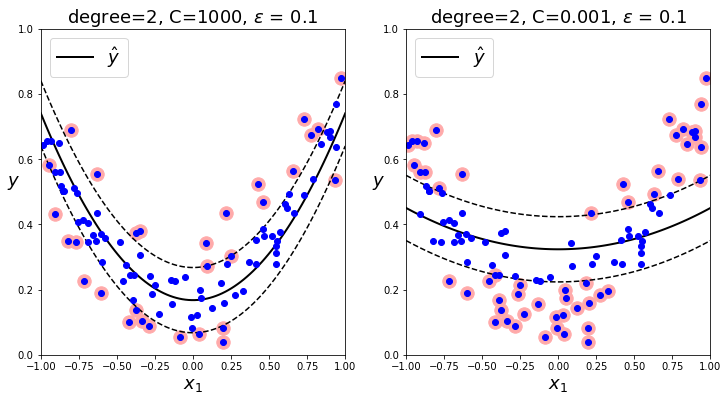

In [9]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(
        X[svm_reg.support_],
        y[svm_reg.support_],
        s=180,
        facecolors='#FFAAAA',
    )
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)
    plt.title(
        f"degree={svm_reg.degree}, "
        f"C={svm_reg.C}, "
        f"$\epsilon$ = {svm_reg.epsilon}",
        fontsize=18,
    )
    plt.ylabel(r"$y$", fontsize=18, rotation=0)


plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])

plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.show()

**Atividade:** Explique o efeito do parâmetro de regularização C

**R:**

Vamos praticar usando o dataset "California Housing" do scikit-learn

In [10]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [11]:
from pprint import pprint

pprint(housing)

{'DESCR': '.. _california_housing_dataset:\n'
          '\n'
          'California Housing dataset\n'
          '--------------------------\n'
          '\n'
          '**Data Set Characteristics:**\n'
          '\n'
          '    :Number of Instances: 20640\n'
          '\n'
          '    :Number of Attributes: 8 numeric, predictive attributes and the '
          'target\n'
          '\n'
          '    :Attribute Information:\n'
          '        - MedInc        median income in block\n'
          '        - HouseAge      median house age in block\n'
          '        - AveRooms      average number of rooms\n'
          '        - AveBedrms     average number of bedrooms\n'
          '        - Population    block population\n'
          '        - AveOccup      average house occupancy\n'
          '        - Latitude      house block latitude\n'
          '        - Longitude     house block longitude\n'
          '\n'
          '    :Missing Attribute Values: None\n'
          

In [12]:
print(housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [13]:
X = pd.DataFrame(housing['data'], columns=housing['feature_names'])
y = pd.Series(housing['target'], name='MedHouseValue')

In [14]:
y.describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseValue, dtype: float64

In [15]:
y[y >= 5.0]

89       5.00001
459      5.00001
493      5.00001
494      5.00001
509      5.00001
          ...   
20422    5.00001
20426    5.00001
20427    5.00001
20436    5.00001
20443    5.00001
Name: MedHouseValue, Length: 992, dtype: float64

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


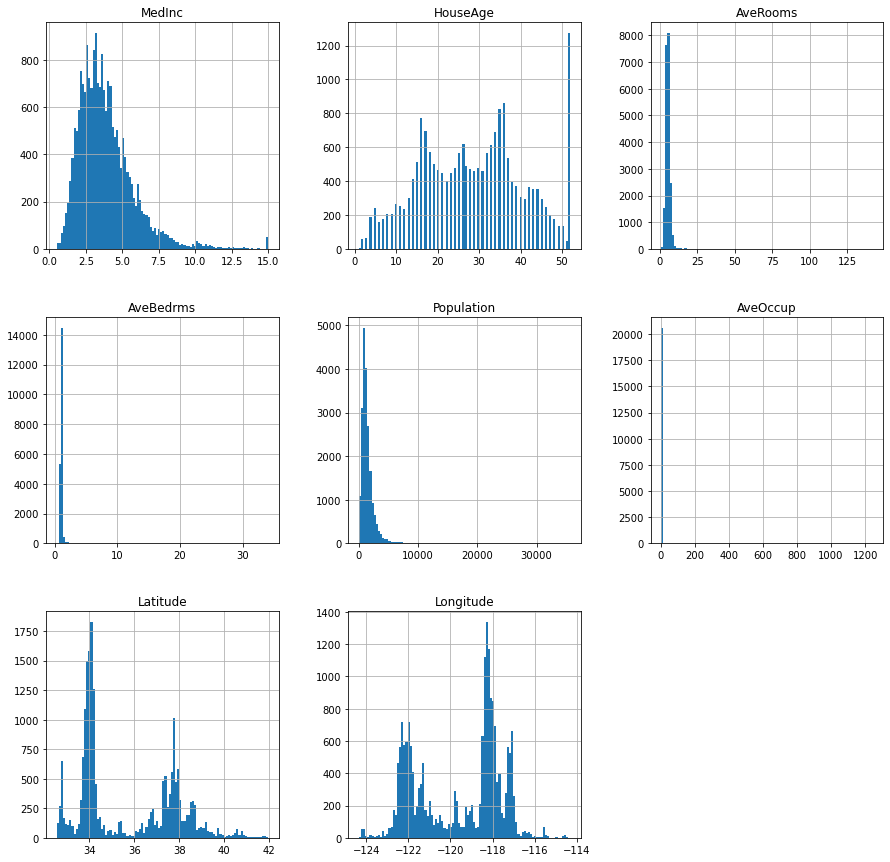

In [17]:
X.hist(figsize=(15, 15), bins=100)
plt.show()

In [18]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Tem uns outliers malucos aparentemente! Onde já se viu um distrito onde a ocupação média dos imóveis é mais de 1000 pessoas!

In [19]:
X[X.AveOccup > 100]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
3364,5.5179,36.0,5.142857,1.142857,4198.0,599.714286,40.41,-120.51
13034,6.1359,52.0,8.275862,1.517241,6675.0,230.172414,38.69,-121.15
16669,4.2639,46.0,9.076923,1.307692,6532.0,502.461538,35.32,-120.70
19006,10.2264,45.0,3.166667,0.833333,7460.0,1243.333333,38.32,-121.98


**Atividade:** Descubra o que aconteceu.

**R:**

 Parece que essas "casas" tem ocupação alta mesmo, ainda mais nos Estados Unidos (e no Brasil). 
 
Temos um problema também em relação ao número de cômodos:

In [20]:
X[X.AveRooms > 50]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
1912,4.9750,16.0,56.269231,10.153846,54.0,2.076923,39.01,-120.16
1913,4.0714,19.0,61.812500,11.000000,112.0,2.333333,39.01,-120.06
1914,1.8750,33.0,141.909091,25.636364,30.0,2.727273,38.91,-120.10
1979,4.6250,34.0,132.533333,34.066667,36.0,2.400000,38.80,-120.08
2395,3.8750,23.0,50.837838,10.270270,64.0,1.729730,37.12,-119.34
9676,3.2431,14.0,52.848214,11.410714,265.0,2.366071,37.64,-119.02
11707,1.1912,22.0,52.690476,8.857143,98.0,2.333333,39.15,-120.06
11862,2.6250,25.0,59.875000,15.312500,28.0,1.750000,40.27,-121.25
12447,1.6154,17.0,62.422222,14.111111,83.0,1.844444,33.97,-114.49


**Atividade:** Explique esse fenômeno também

**R:**

Para não misturar tipos de "residências", vamos filtrar o dataset e eliminar alguns outliers. Vamos nos restringir a um número de cômodos menor que 15, e uma ocupação média menor que 10. 

Vamos também eliminar os distritos onde o valor mediano dos imóveis excede $5.0$.

In [21]:
valid = (X.AveRooms[:] < 15) & (X.AveOccup < 10) & (y < 5.0)
X_filt = X[valid]
y_filt = y[valid]

In [22]:
X_filt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19509 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      19509 non-null  float64
 1   HouseAge    19509 non-null  float64
 2   AveRooms    19509 non-null  float64
 3   AveBedrms   19509 non-null  float64
 4   Population  19509 non-null  float64
 5   AveOccup    19509 non-null  float64
 6   Latitude    19509 non-null  float64
 7   Longitude   19509 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


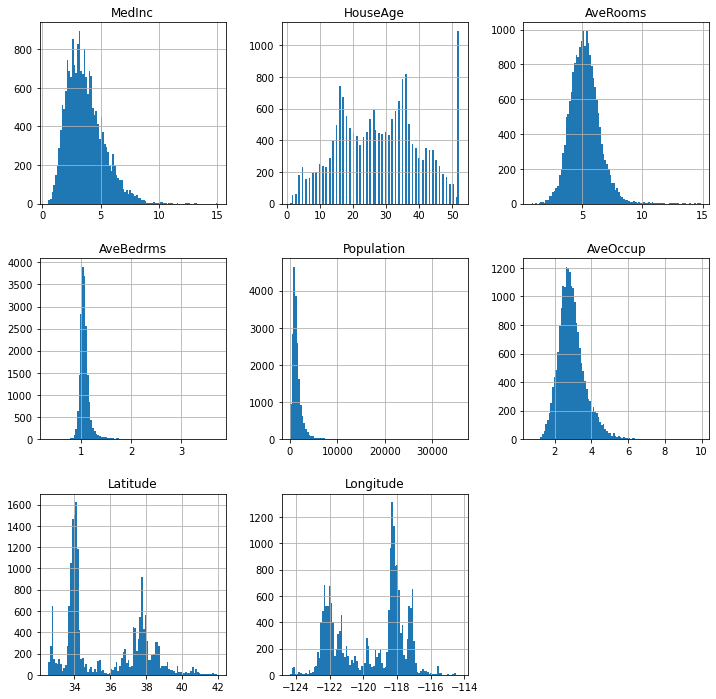

In [23]:
X_filt.hist(figsize=(12, 12), bins=100)
plt.show()

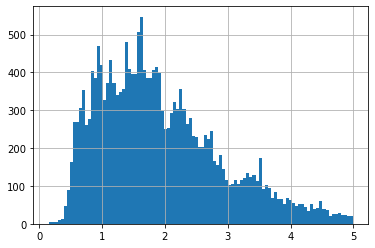

In [24]:
y_filt.hist(bins=100)
plt.show()

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_filt,
    y_filt,
    test_size=0.33,
)

Support Vector Machines são bastante eficientes para conjuntos de dados pequenos, mas seu processo de treinamento é extremamente lento. Para escolher o valor ótimo do parâmetro de regularização $C$ vamos reamostrar os dados e fazer a busca por validação cruzada em um dataset pequeno.

In [26]:
from sklearn.utils import resample

X_train_small, y_train_small = resample(
    X_train,
    y_train,
    replace=False,
    n_samples=500,
)

In [27]:
%%time
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('reg', SVR(C=1, epsilon=0.1)),
    ]),
    {
        'reg__C': [10**k for k in range(-4, 7)],
    },
    scoring='neg_mean_squared_error',
    cv=ShuffleSplit(
        n_splits=100,
        test_size=0.33,
        random_state=RANDOM_SEED,
    ),
    n_jobs=-1,
)

grid.fit(X_train_small, y_train_small)
print(grid.best_params_)

{'reg__C': 1}
Wall time: 32.9 s


0.0001 1.0520660712836707 0.10426337556956786
0.001 1.036385496030064 0.10346533464336279
0.01 0.9108974606295729 0.09633352362604797
0.1 0.5409252349654998 0.06618862835386778
1 0.35454841912678875 0.03659182196349074
10 0.3809283351306001 0.040060405030996504
100 0.6283919944832883 0.07529641782008453
1000 1.0014104148154814 0.1568689669520653
10000 1.0902736052663133 0.19000011558647567
100000 1.0902736052663133 0.19000011558647567
1000000 1.0902736052663133 0.19000011558647567


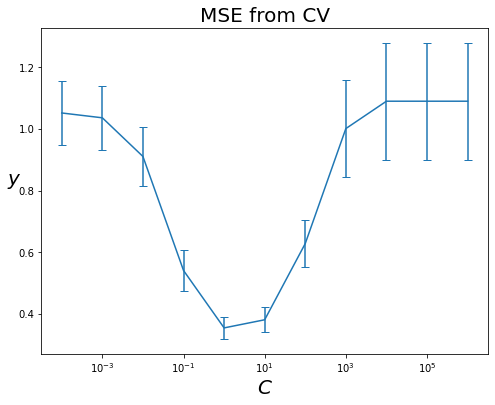

In [28]:
P = [p['reg__C'] for p in grid.cv_results_['params']]
M = -grid.cv_results_['mean_test_score']
S = np.log(grid.cv_results_['std_test_score'] + 1)

for p, m, s in zip(P, M, S):
    print(p, m, s)

plt.figure(figsize=(8, 6))
plt.errorbar(P, M, S, capsize=4)
plt.semilogx()
plt.title('MSE from CV', fontsize=20)
plt.xlabel(r"$C$", fontsize=20)
plt.ylabel(r"$y$", fontsize=20, rotation=0)
plt.show()

**Atividade:** Mais uma vez, explique esse gráfico em termos do tradeoff bias/variance

**R:**

Vamos tentar também ajustar o parâmetro $\gamma$ do modelo (ver 'Gaussian RBF Kernel' no livro texto):

In [29]:
%%time
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('reg', SVR(C=1, epsilon=0.1, gamma=0.1)),
    ]),
    {
        'reg__gamma': [10**k for k in range(-7, 5)],
    },
    scoring='neg_mean_squared_error',
    cv=ShuffleSplit(
        n_splits=100,
        test_size=0.33,
        random_state=RANDOM_SEED,
    ),
    n_jobs=-1,
)

grid.fit(X_train_small, y_train_small)
print(grid.best_params_)

{'reg__gamma': 0.1}
Wall time: 7.78 s


1e-07 1.0537192076441906 0.10437256173935491
1e-06 1.053142166231467 0.10435469685401767
1e-05 1.0472425807560406 0.10406630151344431
0.0001 0.9922869536714076 0.10100152059602127
0.001 0.7107359818163992 0.08297871082907493
0.01 0.4532950623163362 0.05543597516299517
0.1 0.3551823701412977 0.03708480172700775
1 0.5816130338995678 0.06770467115868314
10 1.0043279703867538 0.09716585428770091
100 1.0133862160735894 0.09735769590804237
1000 1.013386241215824 0.0973576955492095
10000 1.013386241215824 0.0973576955492095


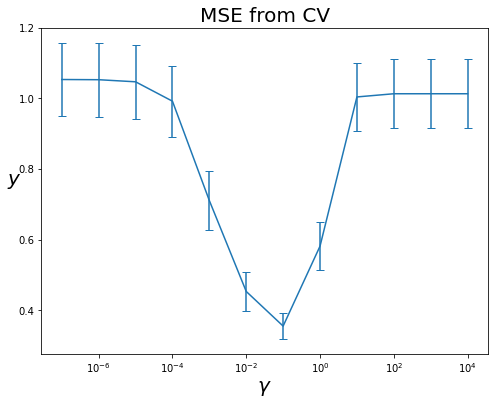

In [30]:
P = [p['reg__gamma'] for p in grid.cv_results_['params']]
M = -grid.cv_results_['mean_test_score']
S = np.log(grid.cv_results_['std_test_score'] + 1)

for p, m, s in zip(P, M, S):
    print(p, m, s)

plt.figure(figsize=(8, 6))
plt.errorbar(P, M, S, capsize=4)
plt.semilogx()
plt.title('MSE from CV', fontsize=20)
plt.xlabel(r"$\gamma$", fontsize=20)
plt.ylabel(r"$y$", fontsize=20, rotation=0)
plt.show()

**Atividade:** yadda yadda yadda tradeoff bias/variance you know what to do :)

**R:**

Finalmente, vamos testar o desempenho final do modelo:

In [31]:
%%time
model = grid.best_estimator_
model.fit(X_train, y_train)

Wall time: 7.67 s


Pipeline(steps=[('scaler', StandardScaler()), ('reg', SVR(C=1, gamma=0.1))])

In [32]:
y_pred = model.predict(X_test)

In [33]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.49805020245496817


Vamos comparar com um regressor linear:

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
%%time
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

Wall time: 22 ms


LinearRegression()

In [36]:
y_pred_lin = lin_reg.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred_lin)))

0.5975183360539157


Parece que o regressor SVM é mais preciso, mas requer um tempo de treinamento várias ordens de magnitude maior que o regressor linear.

**Atividade:** A unidade de medida da variável dependente é "dezenas de milhares de dólares". Explique para seu chefe porque você merece uma promoção pelo seu trabalho com um regressor SVM enquanto seu colega (que não fez a disciplina de Machine Learning) usou uma regressão linear simples.

**R:**

**Atividades:**

- Qual a idéia fundamental das Support Vector Machines? O que são vetores de suporte?

- (Desafio) A segunda idéia mais importante das SVMs é o uso de kernels. Os kernels permitiram a expansão das SVMs para além dos modelos lineares. Em particular, o kernel RBF (radial-basis function) é bastante popular entre os usuários de SVMs, e apresenta desempenho bem elevado em geral. O que são kernels? Qual a sua relação com o problema de otimização dual das SVMs?

- Se dobrarmos o número de features em uma modelagem SVM, quanto sobe o tempo de treinamento de um classificador SVM linear? E de um SVM RBF?

- Se dobrarmos o número de amostras de treinamento de um classificador SVM linear, quanto sobe o tempo de treinamento? E se for um classificador SVM RBF?